# Recherches de Vinciane : accidents et compteurs

In [41]:
# for data
import numpy as np
import pandas as pd


#for plotting
import matplotlib.pyplot as plt
import descartes

## for geospatial
import geopandas as gpd
import folium
#for machine learning 
from sklearn import preprocessing, cluster
import scipy

## for deep learning
#import minisom

A titre informatif : les départements d'idf
Paris (75)
Seine-et-Marne (77)
Yvelines (78)
Essonne (91)
Hauts-de-Seine (92)
Seine-Saint-Denis (93)
Val-de-Marne (94)
Val-d'Oise (95)

## Des données sur les communes

In [2]:
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

#Méthodes utilisées dans le TP de géopandas
def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

download_unzip('https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12')
communes_borders = gpd.read_file(temporary_location + "/borders/communes-20190101.json")

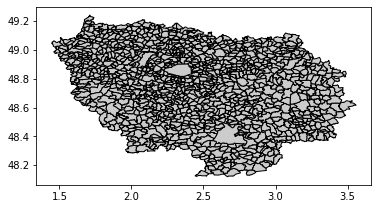

In [3]:
#On indexe par rapport au numéro des départements et on ne garde que les départements d'ile de France qui nous intéressent
data_borders = communes_borders.set_index('insee')
data_borders['dep'] = data_borders.index.str[:2]
communes_idf = data_borders.loc[data_borders['dep'].isin(['75','77', '78', '91','92','93','94', '95'])]
communes_idf.plot(color='0.8', edgecolor='black')

## Les données sur les accidents de vélo

Le site d'où sont tirées les données : https://www.data.gouv.fr/fr/datasets/accidents-de-velo/

In [4]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39')
#accident_velo

C:\Users\Vinciane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]
accident_velo_idf
# Il y a un problème avec les latitudes et les longitudes nulles et les quelques erreurs

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,...,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
58,200500001606,2005-01-13,01 - janvier,3 - jeudi,11.0,78,78230,0.00000,0.00000,oui,...,NaN,NaN,NaN,Véhicule,Avant,Sans changement de direction,200500001606B02,VL seul,Sans changement de direction,1.0
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,95042,49.06400,2.32800,non,...,NaN,NaN,NaN,NaN,Arrière,Sans changement de direction,200500001930B02,Cyclomoteur <50cm3,"Même sens, même file",1.0
221,200500004591,2005-01-04,01 - janvier,1 - mardi,17.0,75,75001,0.00000,0.00000,oui,...,Casque,Oui,NaN,Véhicule,Avant,Sans changement de direction,200500004591B01,VL seul,Ouverture de porte,1.0
222,200500004597,2005-01-03,01 - janvier,0 - lundi,9.0,75,75005,0.00000,0.00000,oui,...,NaN,NaN,NaN,Véhicule,Arrière,Tournant à gauche,200500004597A01,Motocyclette,Sans changement de direction,1.0
223,200500004600,2005-01-03,01 - janvier,0 - lundi,17.0,75,75019,0.00000,0.00000,oui,...,NaN,NaN,NaN,Piéton,Avant,Sans changement de direction,200500004600A01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,201800050291,2018-07-10,07 - juillet,1 - mardi,9.0,75,75101,48.86400,2.33134,oui,...,Casque,Non,Autre obstacle fixe sur chaussée,Véhicule,Avant droit,Sans changement de direction,201800050291B01,VL seul,Ouverture de porte,1.0
65532,201800050337,2018-11-17,11 - novembre,5 - samedi,12.0,75,75101,48.85854,2.34825,oui,...,Casque,Non déterminable,NaN,Véhicule,Côté gauche,Sans changement de direction,201800050337A01,Motocyclette > 125 cm3,Sans changement de direction,1.0
65533,201800050355,2018-02-01,02 - février,3 - jeudi,15.0,75,75102,48.86870,2.34133,oui,...,Casque,Oui,NaN,Véhicule,Avant,"Dans le couloir bus, dans le même sens",201800050355B01,VL seul,Tournant a droite,1.0
65534,201800050359,2018-02-12,02 - février,0 - lundi,9.0,75,75101,48.86470,2.34275,oui,...,Casque,Oui,NaN,Véhicule,Avant gauche,Traversant la chaussée,201800050359B01,Motocyclette > 50 cm3 et <= 125 cm3,Dépassant à gauche,1.0


Pour les valeurs des longitudes et latitudes, j'ai cherché sur maps les latitudes et longitudes max d'ile de France.. 
On obtient

longitude min = 1,44 longitude max = 3,57
latitude min = 48.12 , latitude max= 49.2

In [6]:
#On transforme les coordonnées latitudes/longitudes en coordonnées lisibles par géopandas
#utilisation du tutos sur : https://geopandas.org/gallery/create_geopandas_from_pandas.html
gdf = gpd.GeoDataFrame(accident_velo_idf, geometry=gpd.points_from_xy(accident_velo_idf.lon, accident_velo_idf.lat))
#print (gdf.head)
gdf = gdf.cx[1.44:3.57,48.12:49.2]
gdf
#On remarque qu'il nous reste 3400 données, ce qui est représentatif des 18 000 données 

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,...,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules,geometry
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,95042,49.06400,2.32800,non,...,NaN,NaN,NaN,Arrière,Sans changement de direction,200500001930B02,Cyclomoteur <50cm3,"Même sens, même file",1.0,POINT (2.32800 49.06400)
1142,200500024289,2005-04-10,04 - avril,6 - dimanche,9.0,78,78497,48.69700,1.77100,non,...,NaN,NaN,Véhicule,Avant,Déporté à gauche,200500024289A01,NaN,NaN,NaN,POINT (1.77100 48.69700)
1143,200500024300,2005-04-24,04 - avril,6 - dimanche,18.0,78,78062,48.85000,1.89000,oui,...,Oui,NaN,Véhicule,Avant,Sans changement de direction,200500024300B02,VL seul,Tournant à gauche,1.0,POINT (1.89000 48.85000)
1149,200500024520,2005-04-03,04 - avril,6 - dimanche,12.0,91,91105,48.57500,2.16600,oui,...,Oui,NaN,NaN,NaN,"Même sens, même file",200500024520B02,VL seul,"Même sens, même file",1.0,POINT (2.16600 48.57500)
1152,200500024639,2005-04-05,04 - avril,1 - mardi,11.0,78,78143,48.73000,2.10000,oui,...,NaN,NaN,Véhicule,Avant droit,Sans changement de direction,200500024639B02,VL seul,Traversant la chaussée,1.0,POINT (2.10000 48.73000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,201800050291,2018-07-10,07 - juillet,1 - mardi,9.0,75,75101,48.86400,2.33134,oui,...,Non,Autre obstacle fixe sur chaussée,Véhicule,Avant droit,Sans changement de direction,201800050291B01,VL seul,Ouverture de porte,1.0,POINT (2.33134 48.86400)
65532,201800050337,2018-11-17,11 - novembre,5 - samedi,12.0,75,75101,48.85854,2.34825,oui,...,Non déterminable,NaN,Véhicule,Côté gauche,Sans changement de direction,201800050337A01,Motocyclette > 125 cm3,Sans changement de direction,1.0,POINT (2.34825 48.85854)
65533,201800050355,2018-02-01,02 - février,3 - jeudi,15.0,75,75102,48.86870,2.34133,oui,...,Oui,NaN,Véhicule,Avant,"Dans le couloir bus, dans le même sens",201800050355B01,VL seul,Tournant a droite,1.0,POINT (2.34133 48.86870)
65534,201800050359,2018-02-12,02 - février,0 - lundi,9.0,75,75101,48.86470,2.34275,oui,...,Oui,NaN,Véhicule,Avant gauche,Traversant la chaussée,201800050359B01,Motocyclette > 50 cm3 et <= 125 cm3,Dépassant à gauche,1.0,POINT (2.34275 48.86470)


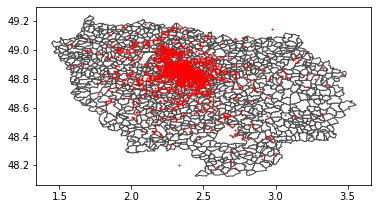

In [7]:
#Première carte, pas ouf
fig, ax = plt.subplots()
communes_idf.plot(ax=ax, color='white', edgecolor='0.3')
gdf.plot(ax=ax, color='red', markersize=1)
plt.show()

Si on essaye de passer par géopandas
accident_velo2 = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/edef9d7e-d574-4203-b4ce-40328edb8298')

## Faire une carte interactive sur les accidents

In [8]:
from folium.plugins import MarkerCluster

In [9]:
#Deuxième carte : des clusters sont fait automatiquement par secteur ou les points sont proches
Paris = [48.85, 2.34]
map_accident = folium.Map(location = Paris , zoom_start=12)

marker_cluster = MarkerCluster().add_to(map_accident)

lat = gdf.lat
lng = gdf.lon
for lat, lng in zip(lat, lng):
    folium.Marker(location=[lat,lng]).add_to(marker_cluster)

map_accident

Idée pour améliorer : 

-différencier les accidents "légers" et les accidents "graves", avec des nuances de points, pour vraiment localiser les endroits à risque
Le but de la localisation des accidents : prévenir les usagers qu'ils passent par une zone à risque. 
Dnas les prolongements, on pourrait créer un mode "safe" pour ceux qui veulent faire du vélo avec leurs enfants.

en gros, je voudrais situer tous les endroits ou y a eu une collision : tous les points qui sotn des clusters à l'échelle 0

## Pour prolonger avec autant de clusters d'accidents que je souhaite : 

Aller voir sur le site : https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1
autre site : https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
autre site utile : https://medium.com/datadriveninvestor/weighted-k-means-clustering-of-gps-coordinates-python-7c6270846163

In [10]:
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

In [11]:
#k means correspond au nombre optimal de clusters, que nous ne connaissons pas encore, je dirais 250 moi

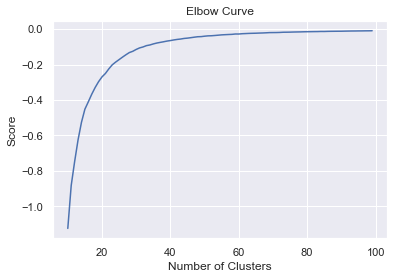

In [12]:
K_clusters = range(10,100)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = gdf[['lat']]
X_axis = gdf[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [55]:
#on définit pour la suite le nombre de clusters qu'on souhaite
k =75

In [56]:
X=gdf.loc[:,['identifiant accident','lat','lon']]

In [57]:
kmeans = KMeans(n_clusters = k, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.sort_values(by = 'lat').head(10)

,identifiant accident,lat,lon,cluster_label
52055,201500034057,48.18055,2.72113,32
52054,201500034057,48.18055,2.72113,32
16275,200800007009,48.19000,2.59200,32
16276,200800007009,48.19000,2.59200,32
62005,201700040745,48.20000,2.33000,70
49800,201500009244,48.23190,2.68456,32
13046,200700041214,48.24400,2.90300,58
45061,201400009446,48.24400,2.98100,58
63789,201800004823,48.26309,2.90225,58
8551,200600052493,48.27400,2.86100,58


Text(0, 0.5, 'longitude')

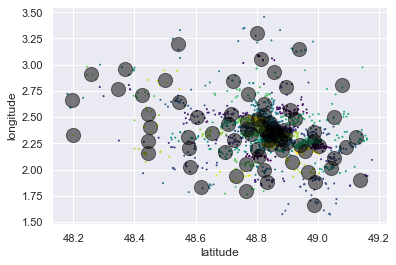

In [58]:
plt.scatter(x = X.lat, y = X.lon, s=1, c=labels,cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha =0.5, c='black')
plt.xlabel('latitude')
plt.ylabel('longitude')

In [64]:
model = cluster.AffinityPropagation()
k = X["cluster_label"].nunique()

Text(0.5, 1.0, 'Clustering (k=75)')

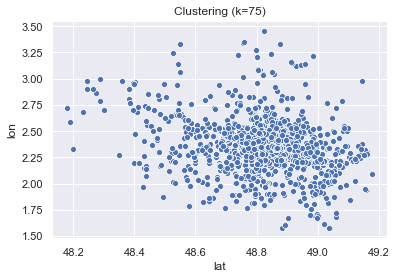

In [65]:
sns.scatterplot(x= X.lat, y=X.lon, 
                palette=sns.color_palette("bright", k),
                legend="brief").set_title('Clustering (k='+str(k)+')')

In [37]:
X = X[['identifiant accident','cluster_label']]
X.head(5)

,identifiant accident,cluster_label
61,200500001930,45
1142,200500024289,58
1143,200500024300,40
1149,200500024520,53
1152,200500024639,48


In [38]:
clustered_data = gdf.merge(X, left_on='identifiant accident', right_on='identifiant accident')
clustered_data.head(5)

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,...,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules,geometry,cluster_label
0,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,95042,49.064,2.328,non,...,NaN,NaN,Arrière,Sans changement de direction,200500001930B02,Cyclomoteur <50cm3,"Même sens, même file",1.0,POINT (2.32800 49.06400),45
1,200500024289,2005-04-10,04 - avril,6 - dimanche,9.0,78,78497,48.697,1.771,non,...,NaN,Véhicule,Avant,Déporté à gauche,200500024289A01,NaN,NaN,NaN,POINT (1.77100 48.69700),58
2,200500024300,2005-04-24,04 - avril,6 - dimanche,18.0,78,78062,48.850,1.890,oui,...,NaN,Véhicule,Avant,Sans changement de direction,200500024300B02,VL seul,Tournant à gauche,1.0,POINT (1.89000 48.85000),40
3,200500024520,2005-04-03,04 - avril,6 - dimanche,12.0,91,91105,48.575,2.166,oui,...,NaN,NaN,NaN,"Même sens, même file",200500024520B02,VL seul,"Même sens, même file",1.0,POINT (2.16600 48.57500),53
4,200500024639,2005-04-05,04 - avril,1 - mardi,11.0,78,78143,48.730,2.100,oui,...,NaN,Véhicule,Avant droit,Sans changement de direction,200500024639B02,VL seul,Traversant la chaussée,1.0,POINT (2.10000 48.73000),48


## Les données sur les aménagements temporaires en Ile de France

le fichier à télécharger est ici : https://velo.smartidf.services/donnees, dans comptage vélo - Données compteurs 

In [16]:
am_temporaires = gpd.read_file('D:/Données/ENSAE/2A/Python/amenagements-velo-temporaires-en-ile-de-france.geojson')
am_temporaires

,highway,ad,nv,ag,geometry
0,primary,bande uni,None,None,"LINESTRING (2.31015 48.89828, 2.30998 48.89878..."
1,primary,bande uni,None,None,"LINESTRING (2.45466 48.90704, 2.45511 48.90692..."
2,primary,bande uni,None,None,"LINESTRING (2.46184 48.90629, 2.46091 48.90651..."
3,primary,bande uni,None,None,"LINESTRING (2.43624 48.91305, 2.43611 48.91312..."
4,primary,bande uni,None,None,"LINESTRING (2.42081 48.93008, 2.42173 48.93094..."
...,...,...,...,...,...
1645,primary,bande uni,None,None,"LINESTRING (2.40344 48.91403, 2.40355 48.91413..."
1646,primary,bande uni,None,None,"LINESTRING (2.40610 48.91650, 2.40616 48.91655..."
1647,primary,bande uni,None,None,"LINESTRING (2.41815 48.92784, 2.41776 48.92749..."
1648,primary,bande uni,None,None,"LINESTRING (2.43121 48.91442, 2.43126 48.91440..."


In [17]:
coordonnees = am_temporaires.geometry
coordonnees
# BUT :extraire les deux premières, les mettre entre parenthèse et les autres dans une autre colonne

0       LINESTRING (2.31015 48.89828, 2.30998 48.89878...
1       LINESTRING (2.45466 48.90704, 2.45511 48.90692...
2       LINESTRING (2.46184 48.90629, 2.46091 48.90651...
3       LINESTRING (2.43624 48.91305, 2.43611 48.91312...
4       LINESTRING (2.42081 48.93008, 2.42173 48.93094...
                              ...                        
1645    LINESTRING (2.40344 48.91403, 2.40355 48.91413...
1646    LINESTRING (2.40610 48.91650, 2.40616 48.91655...
1647    LINESTRING (2.41815 48.92784, 2.41776 48.92749...
1648    LINESTRING (2.43121 48.91442, 2.43126 48.91440...
1649    LINESTRING (2.42395 48.93320, 2.42386 48.93311...
Name: geometry, Length: 1650, dtype: geometry

Bon site : https://codesturm.eu/geolocalisation/

map = folium.Map(location = [48.85, 2.34], zoom_start=12)
feature_group2 = folium.FeatureGroup("Pistes temporaires")
coordinates = am_temporaires.geometry
for coordinates in zip(coordinates):
    aline=folium.PolyLine(locations=coordinates,weight=2,color = 'blue') 
m.add_children(aline) 

coordinates=[(32.900908, -97.040335),(40.768571, -73.861603)] 

m = folium.Map(location=[32.900908, -97.040335], zoom_start=4) 

#line going from dfw to lga 
aline=folium.PolyLine(locations=coordinates,weight=2,color = 'blue') 
m.add_children(aline) 

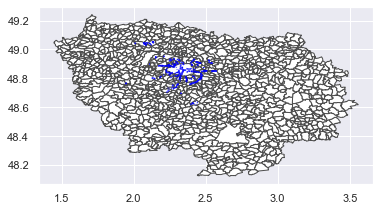

In [18]:
fig, ax = plt.subplots()
communes_idf.plot(ax=ax, color='white', edgecolor='0.3')
am_temporaires.plot(ax=ax, color='blue')
plt.show()

### Des données sur les compteurs dans Paris

In [19]:
compteurs2 = pd.read_json('D:/Données/ENSAE/2A/Python/comptage-velo-donnees-compteurs.json')
compteurs2
#Cette base de donnée n'est pas lisible de la bonne manière => des idées?

,datasetid,recordid,fields,geometry,record_timestamp
0,comptage-velo-donnees-compteurs,a60867327acd1993730d092c4bfe5d7bcb2c1611,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.33338, 48....",2020-11-06T08:00:15.819+01:00
1,comptage-velo-donnees-compteurs,27c208904219bc7c482fe30631c5562962673d43,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.33338, 48....",2020-11-06T08:00:15.819+01:00
2,comptage-velo-donnees-compteurs,2a75968d2e3627f43a1877058740111d30cbad07,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.33338, 48....",2020-11-06T08:00:15.819+01:00
3,comptage-velo-donnees-compteurs,1c3349316233d7eb1b11eef69b7bdad36d7414a2,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.33338, 48....",2020-11-06T08:00:15.819+01:00
4,comptage-velo-donnees-compteurs,13114b02937d45554cc7dbf86ab591e0a191773a,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.33338, 48....",2020-11-06T08:00:15.819+01:00
...,...,...,...,...,...
820191,comptage-velo-donnees-compteurs,69c5dec9592a7f35ae42c10ba1be870d8d914010,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.345648, 48...",2020-11-06T08:29:44.372+01:00
820192,comptage-velo-donnees-compteurs,1342b1affb23017a426a15fcf46eac01552c1088,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.345648, 48...",2020-11-06T08:29:44.372+01:00
820193,comptage-velo-donnees-compteurs,89b911a144638e304715e8eb1f24d3fc55774859,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.345648, 48...",2020-11-06T08:29:44.372+01:00
820194,comptage-velo-donnees-compteurs,f369092cd2478e5d465b64e2c7e0ac245e95e38d,{'url_photos_n1': 'https://www.eco-visio.net/P...,"{'type': 'Point', 'coordinates': [2.345648, 48...",2020-11-06T08:29:44.372+01:00


lien utile pour choisir la position de départ sur la carte  : https://python-visualization.github.io/folium/quickstart.html
il génère un oblget popu quand on clique à un endroit sur la carte

Pour les compteurs on a des données aussi : https://www.data.gouv.fr/fr/datasets/comptage-velo-historique-donnees-compteurs/

## Travail en cours sur la création de trajet grâce aux données sur les routes